<a href="https://colab.research.google.com/github/Romasha-Guin/Final-Year-Project/blob/main/ASR_using_CTC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 4.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [3]:
# Downloading and preparing data
data_url = "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"
data_path = keras.utils.get_file("LJSpeech-1.1", data_url, untar=True)
wavs_path = data_path + "/wavs/"
metadata_path = data_path + "/metadata.csv"

2748572632/2748572632 [==============================] - 37s 0us/step


In [4]:
# Reading metadata and shuffling the data
metadata_df = pd.read_csv(metadata_path, sep="|", header=None, quoting=3)
metadata_df.columns = ["file_name", "transcription", "normalized_transcription"]
metadata_df = metadata_df[["file_name", "normalized_transcription"]]
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)

In [5]:
# Splitting data into training and validation sets
split = int(len(metadata_df) * 0.90)
df_train = metadata_df[:split]
df_val = metadata_df[split:]

In [6]:
# Displaying the size of the datasets
print(f"Size of the training set: {len(df_train)}")
print(f"Size of the validation set: {len(df_val)}")

Size of the training set: 11790
Size of the validation set: 1310


In [7]:
# Defining characters and mapping to numbers
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

In [8]:
# Setting up spectrogram parameters
frame_length = 256
frame_step = 160
fft_length = 384

In [9]:
# Function to encode a single sample
def encode_single_sample(file_name, label):
    file = tf.io.read_file(wavs_path + file_name + ".wav")
    audio, _ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio, axis=-1)
    audio = tf.cast(audio, tf.float32)

    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)

    label = tf.strings.lower(label)
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    label = char_to_num(label)

    return spectrogram, label

In [10]:
# Creating training and validation datasets
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["file_name"]), list(df_train["normalized_transcription"]))
)
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["file_name"]), list(df_val["normalized_transcription"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

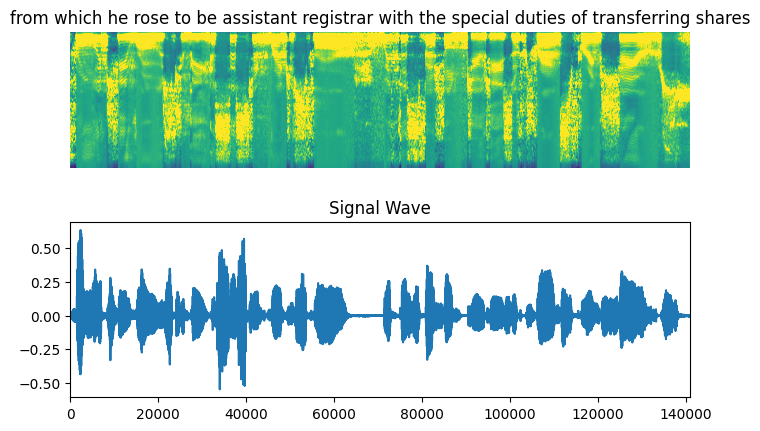

In [11]:
# Displaying a sample from the training dataset
fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]

    # Spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")

    # Wav
    file = tf.io.read_file(wavs_path + list(df_train["file_name"])[0] + ".wav")
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()

In [12]:
# Defining the CTC loss function
def ctc_loss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [13]:
# Building the DeepSpeech 2 model
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    input_spectrogram = layers.Input((None, input_dim), name="input")
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)

    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)

    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)

    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)

    model = keras.Model(input_spectrogram, output, name="DeepSpeech2")
    opt = keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=opt, loss=ctc_loss)

    return model

In [14]:
# Creating and summarizing the model
model = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
)
model.summary(line_length=110)

Model: "DeepSpeech2"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input (InputLayer)                              [(None, None, 193)]                         0                
                                                                                                              
 expand_dim (Reshape)                            (None, None, 193, 1)                        0                
                                                                                                              
 conv_1 (Conv2D)                                 (None, None, 97, 32)                        14432            
                                                                                                              
 conv_1_bn (BatchNormalization)                  (None, None, 97, 32)                      

In [15]:
# Function to decode batch predictions
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text

In [16]:
# Callback for evaluation during training
class EvaluationCallback(keras.callbacks.Callback):
    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)

In [17]:
# Training the model
epochs = 1
validation_callback = EvaluationCallback(validation_dataset)
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)

1/1 [==============================] - 3s 3s/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------
Target    : oswald provided little information during his questioning
Prediction: s
----------------------------------------------------------------------------------------------------
Target    : accordingly euins' testimony is considered probative as to the source of the shots but is inconclusive as to the identity of the man in the window
Prediction: ssss
----------------------------------------------------------------------------------------------------
369/369 [==============================] - 2121s 6s/step - loss: 300.0884 - val_loss: 287.5088


In [18]:
# Evaluating the model on the validation set
predictions = []
targets = []
for batch in validation_dataset:
    X, y = batch
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)

wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)

# Displaying random predictions from the validation set
for i in np.random.randint(0, len(predictions), 5):
    print(f"Target    : {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print("-" * 100)

1/1 [==============================] - 1s 597ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------
Target    : he might swear he was not the murderer that he never fired a pistol in his life
Prediction: ssss
----------------------------------------------------------------------------------------------------
Target    : but they proceeded in all seriousness and would have shrunk from no outrage or atrocity in furtherance of their foolhardy enterprise
Prediction: ssss
----------------------------------------------------------------------------------------------------
Target    : it was shown that the will must be a forgery
Prediction: ssr
----------------------------------------------------------------------------------------------------
Target    : marie de roux up to the time of her marriage had been in servi